In [2]:
# prelude
# conda install joblib xgboost numpy pandas matplotlib scikit-learn seaborn -c conda-forge
import pickle
import joblib
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns


# -----------------------------------------------------------------------------
from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618                    # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold

k_random_state  = 42
k_test_size     = 0.2

In [3]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "mean" : Mean value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        match col_dtype:
            case "int64":
                max_of_col  = df[col_name].max()
                min_of_col  = df[col_name].min()
                mean_of_col = df[col_name].mean()
                outlier_hi  = df[col_name].mean() + 3*df[col_name].std()
                outlier_lo  = df[col_name].mean() - 3*df[col_name].std()
            case "bool":
                max_of_col  = int(df[col_name].max())
                min_of_col  = int(df[col_name].min())
                mean_of_col = float(df[col_name].mean())
                outlier_hi  = 1 
                outlier_lo  = 0 
            case _:                        # "object" ...
                max_of_col = -1
                min_of_col =  1
                mean_of_col = np.nan
                outlier_hi = -1
                outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2),
            "min"                 : round(min_of_col,2),
            "mean"                : round(mean_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [4]:
# -----------------------------------------------------------------------------
def remove_Outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # TODO try this one day : 
    # df = df[~((df[column] < (Q1 - 1.5*IQR)) | (df[column] > (Q3 + 1.5*IQR)))]
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


# -----------------------------------------------------------------------------
# Remove outliers using z-score
# TODO : try this instead (may be smarter)
# from scipy import stats
# df = df[(np.abs(stats.zscore(df[['price']])) < 3)]

def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df

# -----------------------------------------------------------------------------
# method = "IQR" or "sigma"
# Ex : df = remove_Outliers(df, "rental_price_per_day", method="sigma")
def remove_Outliers(df, column, method="sigma"):
    match method:
        case "IQR":
            df = remove_Outliers_IQR(df, column)
        case "sigma":
            df = remove_Outliers_Sigma(df, column)
        case _:
            raise Exception("method must be IQR or sigma")    
    return df



In [5]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = Path(f"{k_Current_dir/k_AssetsDir/fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [ ]:
# -----------------------------------------------------------------------------
def preprocessor(df):
    # drop
    # df.drop(columns="Unnamed: 7", inplace=True)
    # df.drop_duplicates(inplace=True)

    # rename
    df.rename(
        columns={
            "Unnamed: 0": "id", 
        }, 
        inplace=True
    )

    # format 
    df.columns = df.columns.str.lower()
    # df.columns = df.columns.str.replace("/", "_")

    
                  
    # cast 
    # df['rental_id'] = df['rental_id'].astype(str)
    # df['car_id'] = df['car_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].apply(lambda x: str(int(x)) if not pd.isna(x) else x)

    # other preprocessing should come here
    # df["time_slot"] = (df["hour"]*60 + df["minute"])//k_time_slot_len

    # set index
    df.set_index('id', inplace=True)

    return df

# getaround project - pricing

# <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

# Specifications 

* https://app.jedha.co/course/project-deployment-ft/getaround-analysis-ft


# EDA 

In [6]:
# df = pd.read_csv('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv')
df = pd.read_csv(k_Current_dir/k_AssetsDir/"get_around_pricing_project.csv")

print(f"\n\nPreview of the dataset :")
display(df.sample(15))



Preview of the dataset :


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
1780,1780,Mercedes,181672,105,diesel,white,hatchback,True,True,False,False,True,False,True,115
1412,1412,Renault,119534,120,diesel,grey,estate,True,True,False,False,True,False,True,130
945,945,Citroën,160805,135,diesel,white,estate,False,True,False,False,True,True,True,111
2740,2740,Citroën,113937,120,diesel,white,sedan,True,False,False,True,True,True,True,135
1597,1597,Peugeot,139586,100,diesel,grey,estate,False,True,False,False,True,False,True,79
2419,2419,Volkswagen,88105,120,diesel,grey,hatchback,True,True,False,False,True,False,True,144
1788,1788,BMW,74088,85,diesel,grey,hatchback,False,False,False,False,False,False,True,100
911,911,Citroën,182351,135,diesel,brown,estate,False,True,False,False,False,False,True,98
1639,1639,Audi,193148,155,diesel,grey,estate,True,True,False,False,True,False,True,119
3419,3419,Peugeot,106845,100,diesel,blue,sedan,False,True,False,False,False,False,True,106


## What is Unnamed: 0?

In [7]:
print(len(df))
print(df["Unnamed: 0"].value_counts)


4843
<bound method IndexOpsMixin.value_counts of 0          0
1          1
2          2
3          3
4          4
        ... 
4838    4838
4839    4839
4840    4840
4841    4841
4842    4842
Name: Unnamed: 0, Length: 4843, dtype: int64>


### <span style="color:orange"><b>Comments :</b></span>
*  ``Unnamed: 0`` is an index


## Missing values

In [8]:
print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))




% of missing values :


Unnamed: 0                   0.0
model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

### <span style="color:orange"><b>Comments :</b></span>
* No missing value 


In [10]:
df = preprocessor(df)
print(f"\n\nPreview of the preprocessed dataset :")
# display(df.head())
display(df.sample(15))



Preview of the preprocessed dataset :


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
id,,,,,,,,,,,,,,
2620,Audi,229171,155,diesel,grey,sedan,True,True,True,False,True,False,True,128
3351,Audi,169451,160,diesel,blue,sedan,True,True,False,True,False,False,True,132
815,Citroën,114413,120,diesel,brown,estate,True,True,False,False,False,False,True,119
2518,Renault,172602,85,diesel,black,sedan,False,True,False,False,False,False,True,104
2643,Peugeot,127412,100,diesel,black,sedan,True,True,False,False,False,False,True,109
1736,Peugeot,125547,100,diesel,brown,estate,True,True,False,False,False,False,True,115
945,Citroën,160805,135,diesel,white,estate,False,True,False,False,True,True,True,111
1681,Peugeot,143694,105,diesel,grey,estate,False,True,False,False,True,False,True,107
1701,Peugeot,180120,100,diesel,grey,estate,True,False,False,False,False,True,True,103


## Data overview

In [11]:
print(f"\n\nThis is a regression problem")

print(f"\n\nThe target is rental_price_per_day")

print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   



This is a regression problem


The target is rental_price_per_day


The dataset consists of :
	        2 dimensions
	    4_843 observations
	       14 features    


% of data type :


,types,as_%
bool,7,50.00
object,4,28.57
int64,3,21.43




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
0,model_key,object,0,0.0,4843,28,1.00,1,NaN,-1,-1.00,"{'Citroën': 969, 'Renault': 916, 'BMW': 827, '..."
1,mileage,int64,0,0.0,4843,4786,-39627.42,-64,140962.80,1000376,321553.02,"{94829: 2, 101223: 2, 148328: 2, 116708: 2, 17..."
2,engine_power,int64,0,0.0,4843,61,12.01,0,128.99,423,245.97,"{135: 882, 120: 785, 85: 631, 100: 570, 105: 4..."
3,fuel,object,0,0.0,4843,4,1.00,1,NaN,-1,-1.00,"{'diesel': 4641, 'petrol': 191, 'hybrid_petrol..."
4,paint_color,object,0,0.0,4843,10,1.00,1,NaN,-1,-1.00,"{'black': 1633, 'grey': 1175, 'blue': 710, 'wh..."
5,car_type,object,0,0.0,4843,8,1.00,1,NaN,-1,-1.00,"{'estate': 1606, 'sedan': 1168, 'suv': 1058, '..."
6,private_parking_available,bool,0,0.0,4843,2,0.00,0,0.55,1,1.00,"{True: 2662, False: 2181}"
7,has_gps,bool,0,0.0,4843,2,0.00,0,0.79,1,1.00,"{True: 3839, False: 1004}"
8,has_air_conditioning,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3865, True: 978}"
9,automatic_car,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3881, True: 962}"


### <span style="color:orange"><b>Comments :</b></span>
* Outliers in ``mileage``, `engine_power` and `rental_price_per_day`
* `has_gps`, `has_air_conditioning`, `automatic_car`, `has_speed_regulator` are unbalanced in a ratio of 1 to 4
* `diesel` is by far the most popular engine type (97%, $\frac{4641}{4843}$)

## About model_key

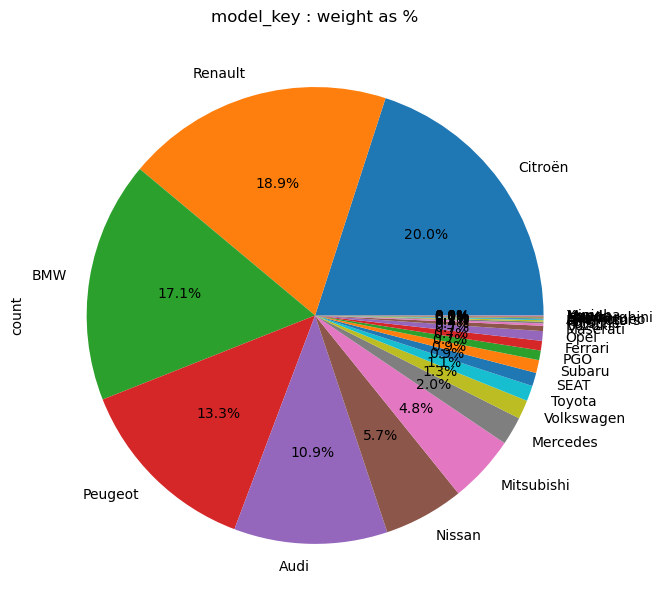

In [12]:
counts = df["model_key"].value_counts()
# print(f"Nb mobile  : {counts['mobile']:>7_}")
# print(f"Nb connect : {counts['connect']:>7_}")

_ = counts.plot.pie(title="model_key : weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

Text(0, 0.5, 'Rental price per day')

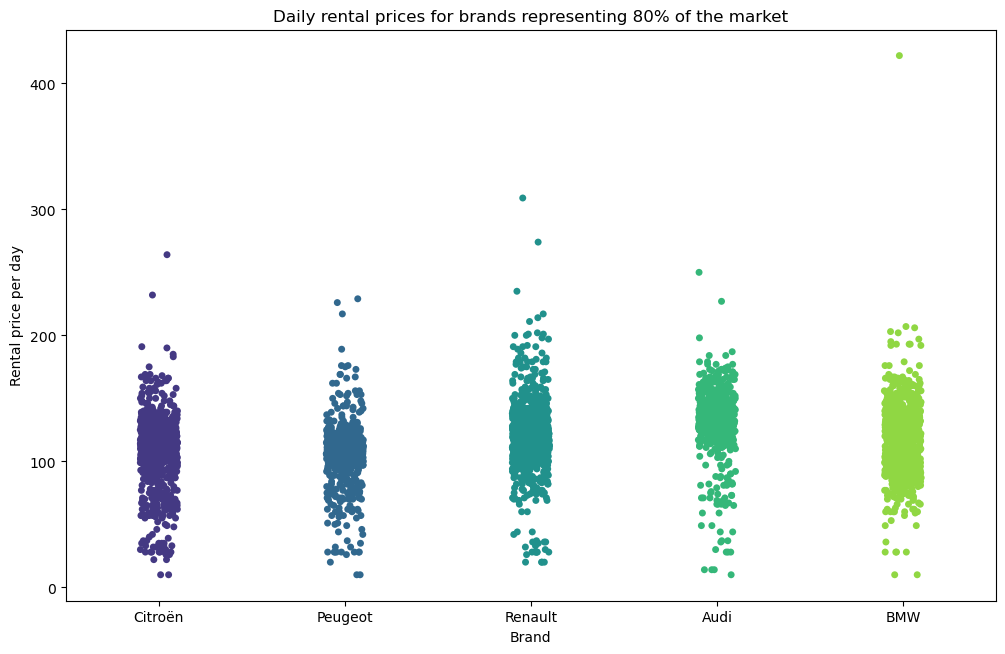

In [33]:
df_tmp = df[df["model_key"].isin(["Citroën", "Renault", "BMW", "Peugeot", "Audi"])]
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
# sns.swarmplot(df_tmp, x="model_key", y="rental_price_per_day", palette="viridis", hue="model_key")
sns.stripplot(df_tmp, x="model_key", y="rental_price_per_day", palette="viridis", hue="model_key")
ax.set_title("Daily rental prices for brands representing 80% of the market")
ax.set_xlabel("Brand")
ax.set_ylabel("Rental price per day")
plt.show()

### <span style="color:orange"><b>Comments :</b></span>
* More than 80% of the cars available covered with 5 different brands ($\frac{5}{28}$, 17%, Pareto is almost verified)  


## Focus on engine_power, mileage and rental_price_per_day

### Shape of the distributions

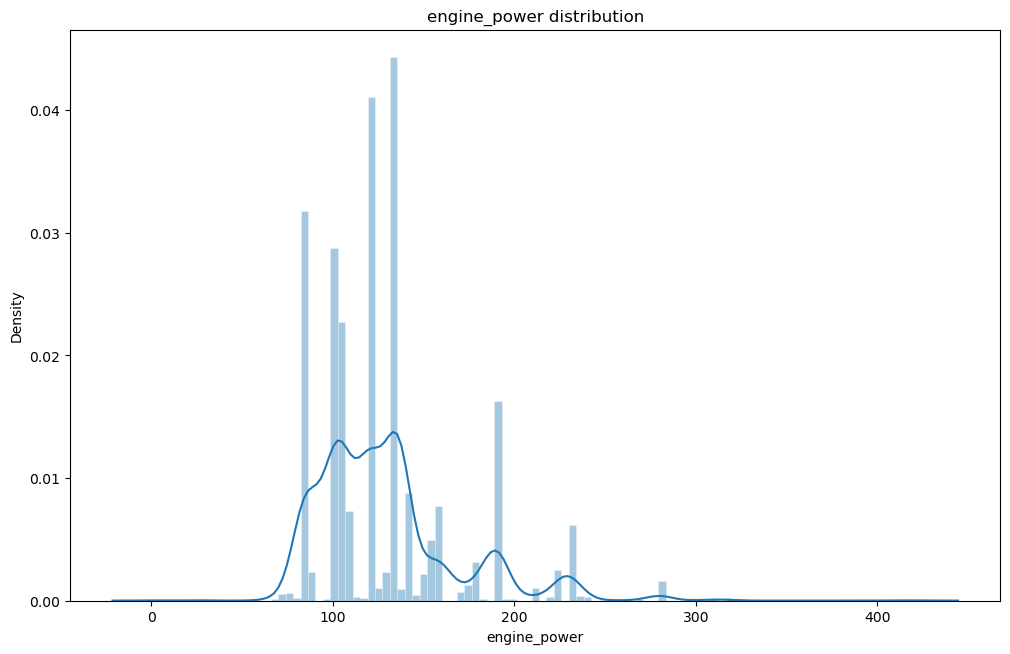

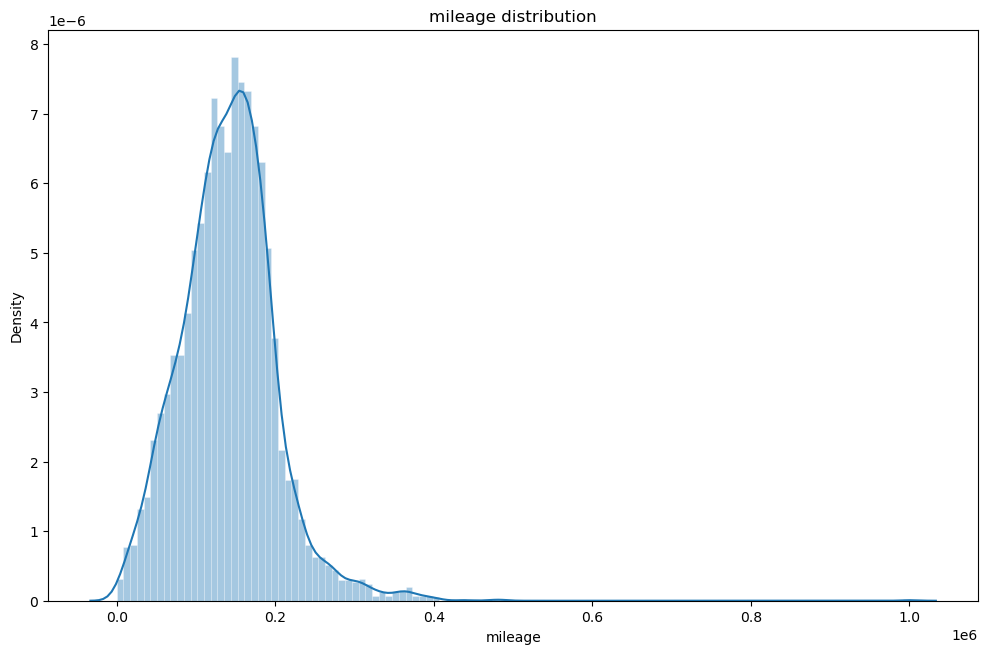

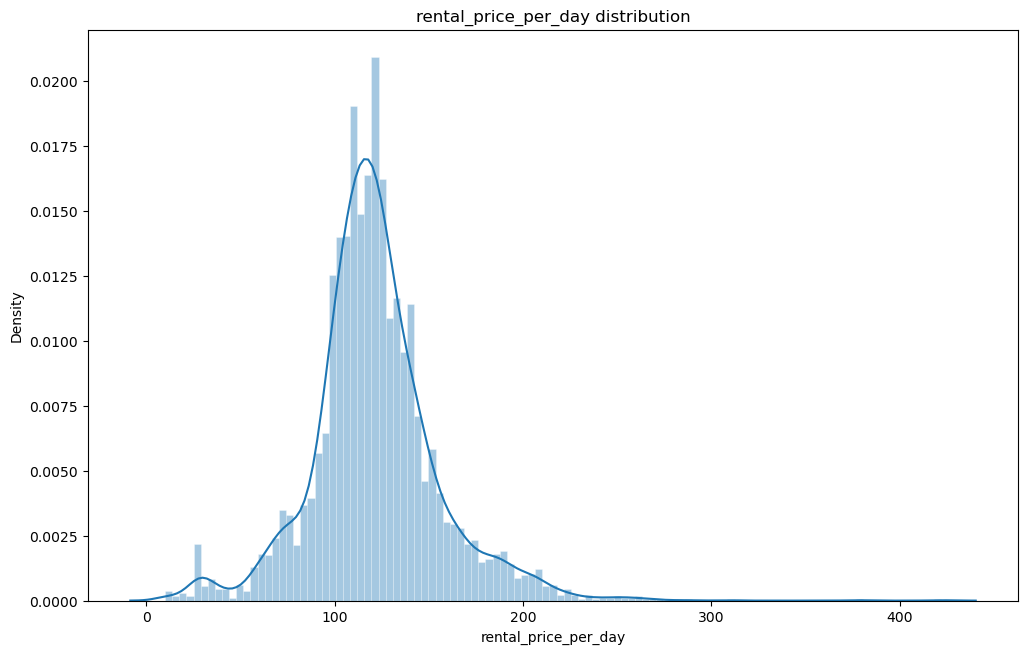

In [13]:
features = ["engine_power", "mileage", "rental_price_per_day"]
for feature in features:
    fig, ax = plt.subplots(figsize=(k_Width,k_Height))
    sns.histplot(df[feature], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4)) 
    ax.set_title(f"{feature} distribution")
    ax.set_xlabel(f"{feature}")


### <span style="color:orange"><b>Comments :</b></span>
* `engine_power` in not a nice bell-curve. If outliers are removed we should use 1.5*IQR 
* ``mileage`` & ``rental_price_per_day`` are considered as bell curves. If outliers are removed we should use 3$\sigma$  


### Vizualise outliers

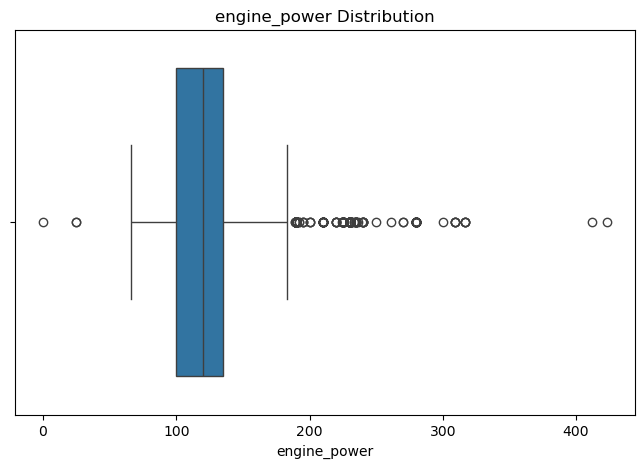

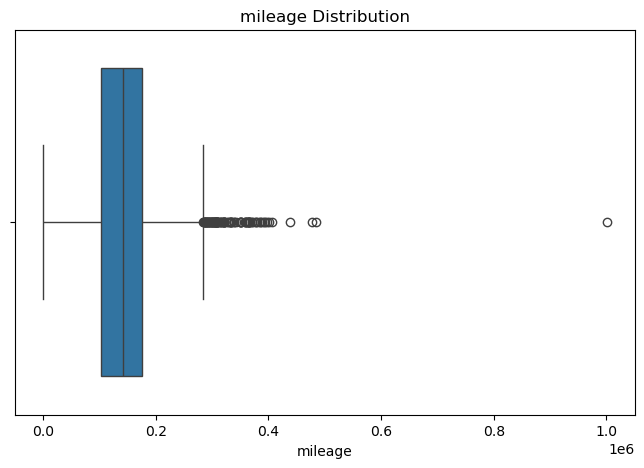

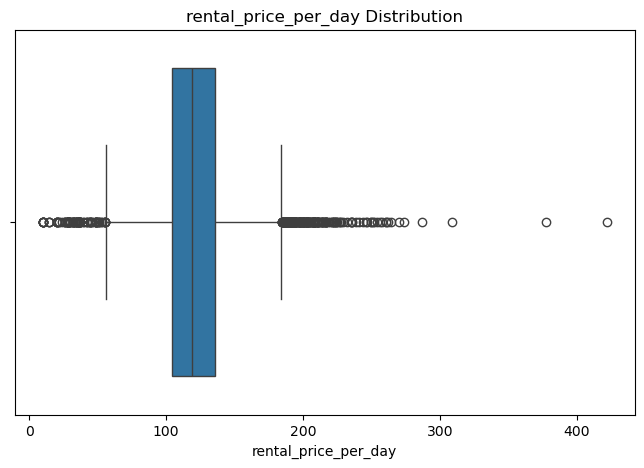

In [14]:
features = ["engine_power", "mileage", "rental_price_per_day"]
for feature in features:
    fig, ax = plt.subplots(figsize=(8,5))
    sns.boxplot(df, x=feature)
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(f"{feature}")

In [15]:
# Using XGBoost I get better results keeping outliers
# Indeed, this model is often robust to outliers as it uses decision trees, which are less sensitive to extreme values. 
# This is, may be, the case here but it seems outliers provide useful information that helps improve predictions

# df = remove_Outliers(df, "engine_power", method="IQR")
# df = remove_Outliers(df, "mileage", method="sigma")
# df = remove_Outliers(df, "rental_price_per_day", method="sigma")

df_tmp = quick_View(df)
print(f"\n\nQuickView after outliers removal:")
display(df_tmp.sort_values(by="# null", ascending=False))   



QuickView after outliers removal:


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
0,model_key,object,0,0.0,4843,28,1.00,1,NaN,-1,-1.00,"{'Citroën': 969, 'Renault': 916, 'BMW': 827, '..."
1,mileage,int64,0,0.0,4843,4786,-39627.42,-64,140962.80,1000376,321553.02,"{94829: 2, 101223: 2, 148328: 2, 116708: 2, 17..."
2,engine_power,int64,0,0.0,4843,61,12.01,0,128.99,423,245.97,"{135: 882, 120: 785, 85: 631, 100: 570, 105: 4..."
3,fuel,object,0,0.0,4843,4,1.00,1,NaN,-1,-1.00,"{'diesel': 4641, 'petrol': 191, 'hybrid_petrol..."
4,paint_color,object,0,0.0,4843,10,1.00,1,NaN,-1,-1.00,"{'black': 1633, 'grey': 1175, 'blue': 710, 'wh..."
5,car_type,object,0,0.0,4843,8,1.00,1,NaN,-1,-1.00,"{'estate': 1606, 'sedan': 1168, 'suv': 1058, '..."
6,private_parking_available,bool,0,0.0,4843,2,0.00,0,0.55,1,1.00,"{True: 2662, False: 2181}"
7,has_gps,bool,0,0.0,4843,2,0.00,0,0.79,1,1.00,"{True: 3839, False: 1004}"
8,has_air_conditioning,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3865, True: 978}"
9,automatic_car,bool,0,0.0,4843,2,0.00,0,0.20,1,1.00,"{False: 3881, True: 962}"


# Model

In [16]:
target_name = "rental_price_per_day"

X = df.drop(columns=target_name)
y = df[target_name]

num_features = X.select_dtypes(include="number").columns
# print(num_features)
cat_features = X.select_dtypes(exclude="number").columns
# print(cat_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state)


In [17]:

num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ('encoder', OneHotEncoder(drop='first')), 
    ]
)


full_pipeline = ColumnTransformer(
    [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

In [18]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

with open(k_Current_dir/k_AssetsDir/'full_pipeline.pkl', 'wb') as file:
    pickle.dump(full_pipeline, file)

In [19]:
# R² : measures the proportion of variance explained by the model
# It is used to judge how close the predictions are to the actual values 
# An R² close to 1 means that the model explains 100% of data variability
# MSE (Mean Squared Error): penalizes larger errors, which can be useful for detecting inaccurate extreme predictions
# MAE (Mean Absolute Error): measures the mean absolute error, giving a simpler, more intuitive idea of the errors committed by the model

# R² train vs. R² test: Compare these two values to check whether your model is overfitting. 
# A large difference between R² train and R² test may indicate overfitting.
# MSE and MAE: These metrics give you an idea of the magnitude of errors. 
# If MSE is much larger than MAE, this may indicate the presence of outliers with a strong impact on the error.

# A good model will have a high test R², close to the train R², and relatively low errors (MSE/MAE). If these errors are low on the test set, this indicates a good ability to generalize.


metrics_df = pd.DataFrame(columns=['Model', 'R2_Train', 'R2_Test', 'MAE', 'MSE'])

## Baseline model - Linear Regression

In [20]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

y_train_pred = lreg.predict(X_train)
r2_train = lreg.score(X_train, y_train)

y_test_pred = lreg.predict(X_test)
r2_test = lreg.score(X_test, y_test)

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
# mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100


row = pd.DataFrame({'Model': ["Linear Reg"], 'R2_Train': [r2_train], 'R2_Test': [r2_test], 'MAE': [mae], 'MSE': [mse]})  
metrics_df = pd.concat([metrics_df, row], ignore_index=True)
display(metrics_df)



C:\Users\phili\AppData\Local\Temp\ipykernel_21788\1516144863.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, row], ignore_index=True)


,Model,R2_Train,R2_Test,MAE,MSE
0,Linear Reg,0.71401,0.693716,12.115364,322.585864


# XGBoost model

* based on decision trees
* several weak models (decision trees, in this case) are combined to form a robust model.
* manage outliers and missing values

Why XGBoost ?
* Never used
* Extreme Grandient Boosting
* Model 1 predictions are compared with true values
* Each model is trained to minimize a loss function that measures the residual error
* Residuals are kept and become the target values
* The new set of weighted observations is injected into model 2
* At the end we have n models
* Submit an observation.
* Sum of the n predictions (residuals) 

In [6]:
# GridSearchCV can be long (45 min. typical)
# Use this switch to, instead, load a pretrained best XGB model and bypass the GridSearchCV()
use_existing_model = True

if use_existing_model:
    best_xgb_model = joblib.load("./assets/model_xgb.pkl")
else :

    reg_xgb = xgboost.XGBRegressor()

    param_grid = {
        # most important
        'n_estimators': [200, 300, 400],            # Number of trees in the model (more trees potentially means better performance, but also more computation time).
        'learning_rate': [0.01, 0.05, 0.1, 0.3],    # The learning rate, which controls the importance given to each tree. Smaller values make the model more accurate, but require more estimators.
        'max_depth': [3, 5, 7, 10],                 # Maximum tree depth. Deeper trees can capture complex relationships, but also risk overfitting.
        
        # important
        # 'subsample': [0.5, 0.7, 0.8, 1],          # Fraction of samples used to fit each trees (can help to reduce overfit)
        'colsample_bytree': [0.5, 0.7, 1],          # Fraction of features used to fit trees (can help to reduce overfit if lot of features)
        'gamma': [0, 0.1, 0.3, 0.5],                # Minimum loss reduction required to make a further partition on a leaf node
        'min_child_weight': [1, 3, 5],              # Minimum leaf weight. Controls the minimum size of a decision node in the tree. A higher weight prevents trees from learning small partitions with little importance, thus avoiding overfitting.
        
        # secondary hyperparameters
        # "lambda" : [0, 0.1, 1, 10],               # lambda L2 regulation  or alpha regulation L1
        # "booster " : "dart"                       # try dart if overfitting (default is gbtree)
    }

    # RandomizedSearchCV() can help at the very beginning. 
    # Then use GridSearchCV() and be prepare to drink lot of green tea
    # grid_search_xgb = RandomizedSearchCV(reg_xgb, param_grid, cv=5, scoring='r2', random_state=k_random_state) 
    grid_search_xgb = GridSearchCV(reg_xgb, param_grid, cv=5, scoring='r2')
    grid_search_xgb.fit(X_train, y_train)
    print("Best hyperparameters : ", grid_search_xgb.best_params_)

    # train
    r2_train = grid_search_xgb.best_score_

    # test
    best_xgb_model = grid_search_xgb.best_estimator_
    y_test_pred_xgb = best_xgb_model.predict(X_test)
    r2_test = best_xgb_model.score(X_test, y_test)
    mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)

    row = pd.DataFrame({'Model': ["XGBoost"], 'R2_Train': [r2_train], 'R2_Test': [r2_test], 'MAE': [mae_xgb], 'MSE': [mse_xgb]})
    metrics_df = pd.concat([metrics_df, row], ignore_index=True)

    display(metrics_df)

    _ = joblib.dump(best_xgb_model, k_Current_dir/k_AssetsDir/"model_xgb.pkl")


# <span style="color:red"><b>Scrap book - Please ignore</b></span>

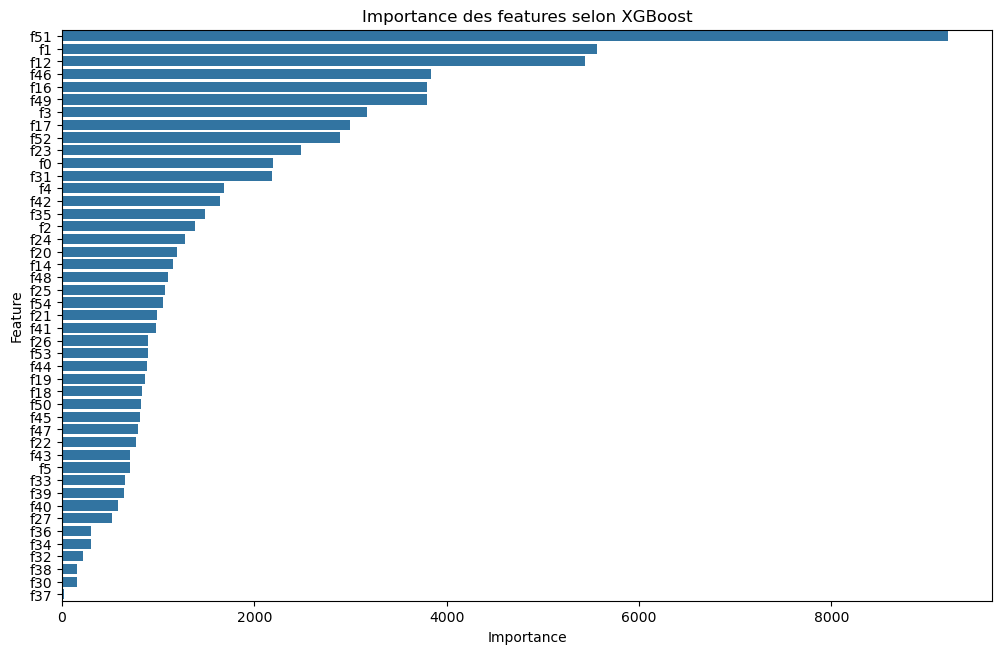

In [9]:
# To see the features, X_train and y_train would have to be passed as a DataFrame to model.fit(X_train, y_train)
# Here, at the output ot the pipeline, they've become dataframes
# I'll see what I can do later...
# In any case, we can see that there are 3 features that are much more important than the others

importance = best_xgb_model.get_booster().get_score(importance_type="gain")

importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])


importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(k_Width, k_Height))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Importance des features selon XGBoost")
plt.show()